In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.layers import LSTM, Dense, Input, Flatten, RepeatVector, Reshape, TimeDistributed, pooling, Convolution1D, MaxPooling1D
from keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
#Display plot inline
%matplotlib inline

In [3]:
def windowing(a, window_lenght=128, step_ahead=1):
    '''Divide a time series in a sequence of fixed-width sliding window of the first n-1 components of input features, 
    and return a target time series of related future values of the last component vector
    
    Args:
    a (list): input array with shape (n_samples, sample_dim)
    window_lenght (int):length of each sample of subsequence.
    step_ahead (int) :stride of sliding window.
    
    Returns:
    x_sample (ndarray): windowed subsequence with shape (n_window, window_lenght, sample_dim-1)
    y_sample (ndarray): = value of time series n step ahead with shape (n_window, 1)
    
    '''
    window_number = (len(a) - step_ahead - window_lenght)
    x_sample = []
    y_sample = []
    for i in range(window_number):
        x_sample.append(a[i:(i + window_lenght), :-1])
        y_sample.append(a[i + window_lenght + step_ahead, -1])

    x_sample = np.asarray(x_sample)
    y_sample = np.asarray(y_sample)

    x_sample = x_sample.reshape((-1, window_lenght, a.shape[1]-1))
    y_sample = y_sample.reshape((-1, 1))

    return x_sample, y_sample

In [4]:
def get_LSTM_autoencoder_model(input_shape=128, input_dim=18, encoded_dim=8, output_dim=1): 
    '''Model factory. It return the models (encoder and autoencoder) to be compiled and trained
    
    Args:
    input_shape (int): Sequence length of input vector
    input_dim (int): Dimension of input vector
    encoded_dim (int): inner vector encoded dimension
    
    Returns:
    encoder (Model): encoder model
    autoencoder (Model): Autoregressive encoder model
    '''
    
    inputs = Input(shape=(input_shape, input_dim))
    lstm1 = LSTM(encoded_dim, activation='tanh')(inputs)
    output = Dense(1)(lstm1)
    autoencoder = Model(inputs, output)
    encoder = Model(inputs, lstm1)
    
    return encoder, autoencoder

In [5]:
def load_training_data(data_folders=range(1,8), test_data=2):
    '''Data Loader. Load experiment datas from folders and returns a single DataFrame
    
    Args:
    data_folders (tuple): range of folders to concatenate (start, end)
    test_data (int): id of sequence to be used for validation tests
    
    Returns:
    
    '''
    training_dataFrame=pd.DataFrame()
    testing_dataFrame=pd.DataFrame()
    for i in data_folders:
        if i == test_data and test_data:
            dx = pd.read_csv('data/Test {}/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
            sx = pd.read_csv('data/Test {}/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
            length=np.max([len(dx), len(sx)])
            sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
            target = np.linspace(0,1,length)
            sequence['target']=target
            testing_dataFrame=testing_dataFrame.append(sequence, ignore_index=True)
            del testing_dataFrame['d0']
            del testing_dataFrame['s0']
            testing_dataFrame=testing_dataFrame.fillna(0)
            continue
            
        dx = pd.read_csv('data/Test {}/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
        sx = pd.read_csv('data/Test {}/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
        length=np.max([len(dx), len(sx)])
        sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
        target = np.linspace(0,1,length)
        sequence['target']=target
        training_dataFrame=training_dataFrame.append(sequence, ignore_index=True)
        del training_dataFrame['d0']
        del training_dataFrame['s0']
        training_dataFrame=training_dataFrame.fillna(0)
    return training_dataFrame, testing_dataFrame

In [6]:
input_shape=128
step_ahead=1

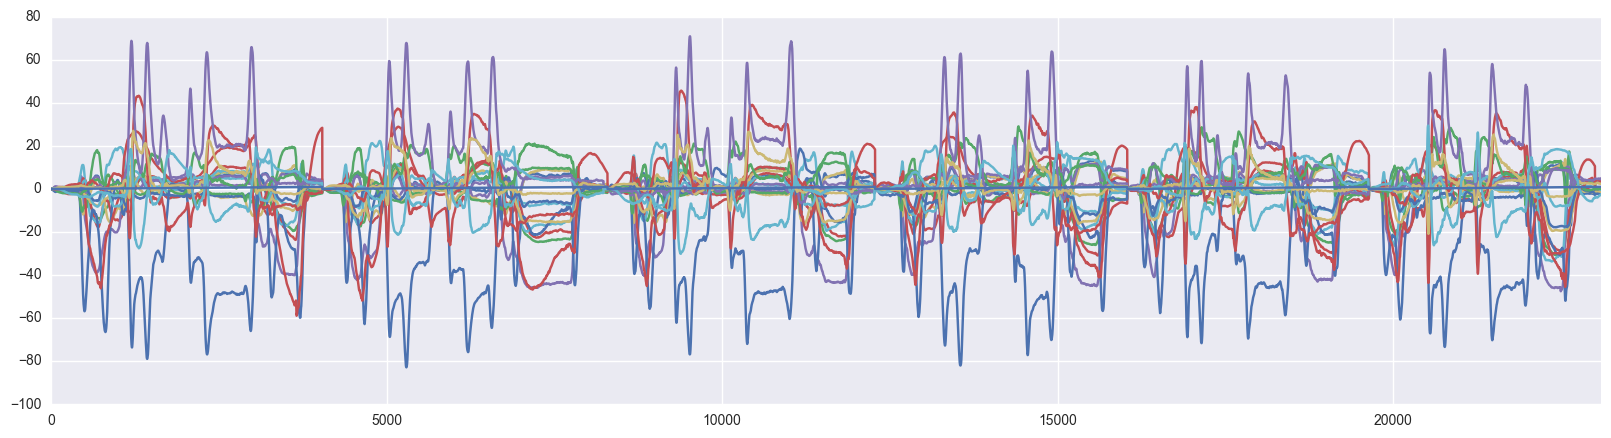

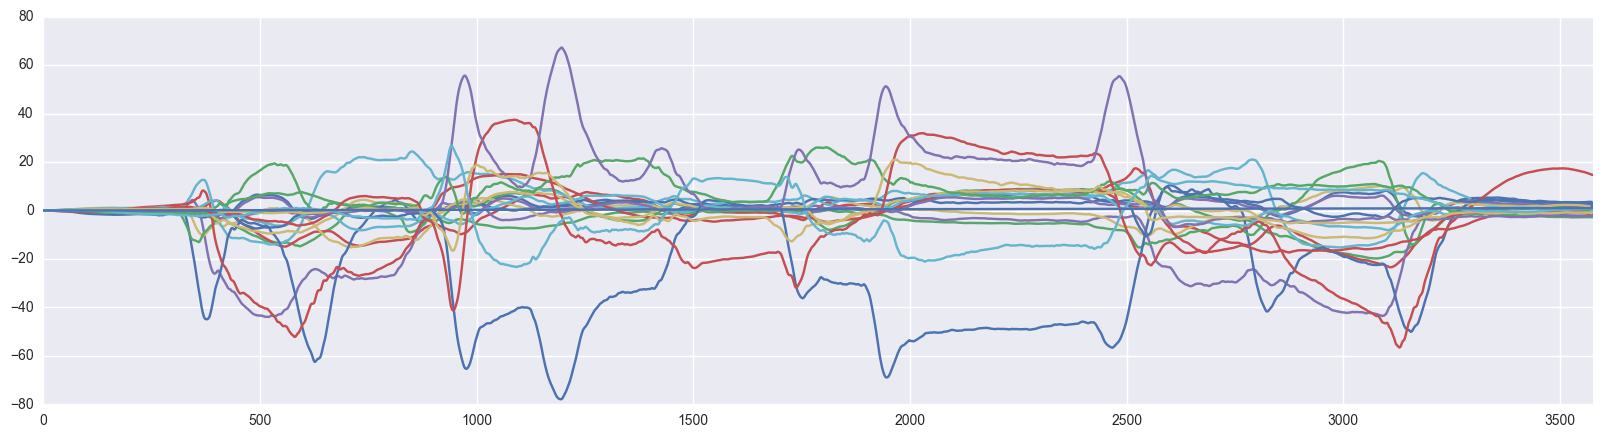

In [15]:
x, x_test=load_training_data(data_folders=range(1,8), test_data=3)
x.plot(figsize=(20,5), legend=False)
if len(x_test)>0:
    x_test.plot(figsize=(20,5), legend=False)

In [16]:
target = x.loc[:,'target']

In [17]:
#Scaling the input data improves the accuracy of LSTM
scaler = MinMaxScaler((-1,1))

In [18]:
x_scaled=scaler.fit_transform(x)
x_test_scaled=scaler.transform(x_test)

In [19]:
x_,y = windowing(x_scaled, window_lenght=input_shape,step_ahead=step_ahead)
x_test_, y_test = windowing(x_test_scaled, window_lenght=input_shape,step_ahead=step_ahead)

In [20]:
encoder, autoencoder = get_LSTM_autoencoder_model(input_shape=128, input_dim=18, encoded_dim=32)
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 18)       0                                            
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 32)            6528        input_2[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             33          lstm_2[0][0]                     
Total params: 6561
____________________________________________________________________________________________________


In [21]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
history=autoencoder.fit(x_,y,nb_epoch=50,verbose=1, batch_size=128, validation_data=(x_test_, y_test), shuffle=False)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [24]:
x_pred=autoencoder.predict(x_)
x_latent = encoder.predict(x_)
x_real=np.reshape(x_[:,input_shape-1,0], (-1,1))

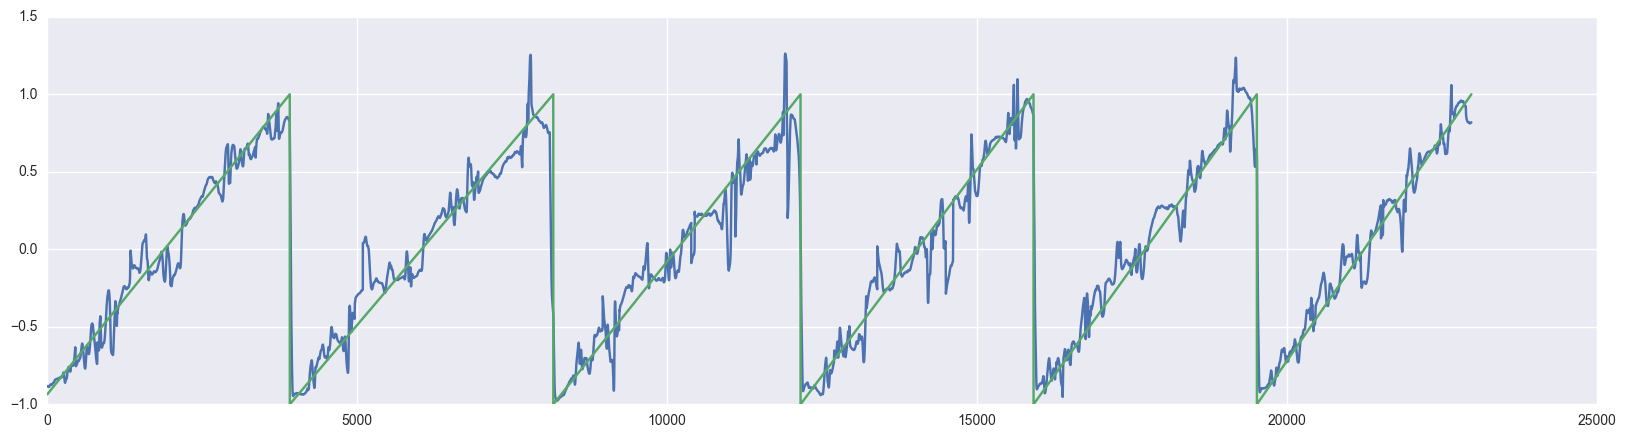

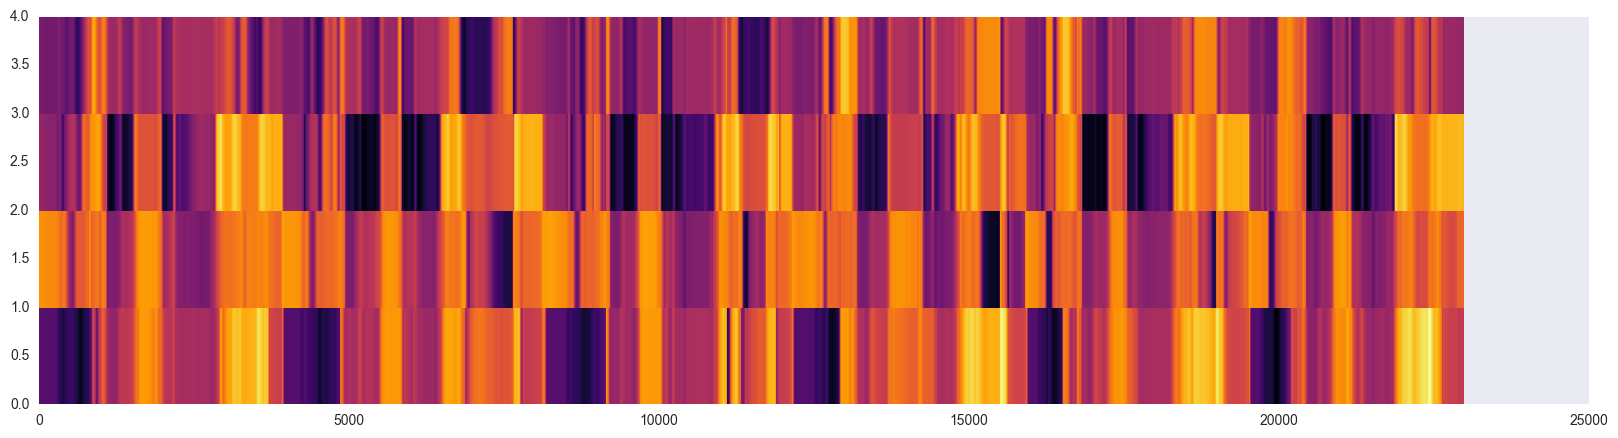

In [25]:
plt.figure(figsize=(20,5))
start=0
size=40000
plt.plot(x_pred[start:start+size,:])
plt.plot(y[start:start+size,:])
plt.figure(figsize=(20,5))
plt.pcolor(x_latent[start:start+size,:4].T, cmap=plt.cm.inferno)

In [26]:
start=0
size=35000
error=(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1])
sigma3=error.std()*3

In [27]:
graph=np.asarray(x.iloc[:,:-1])

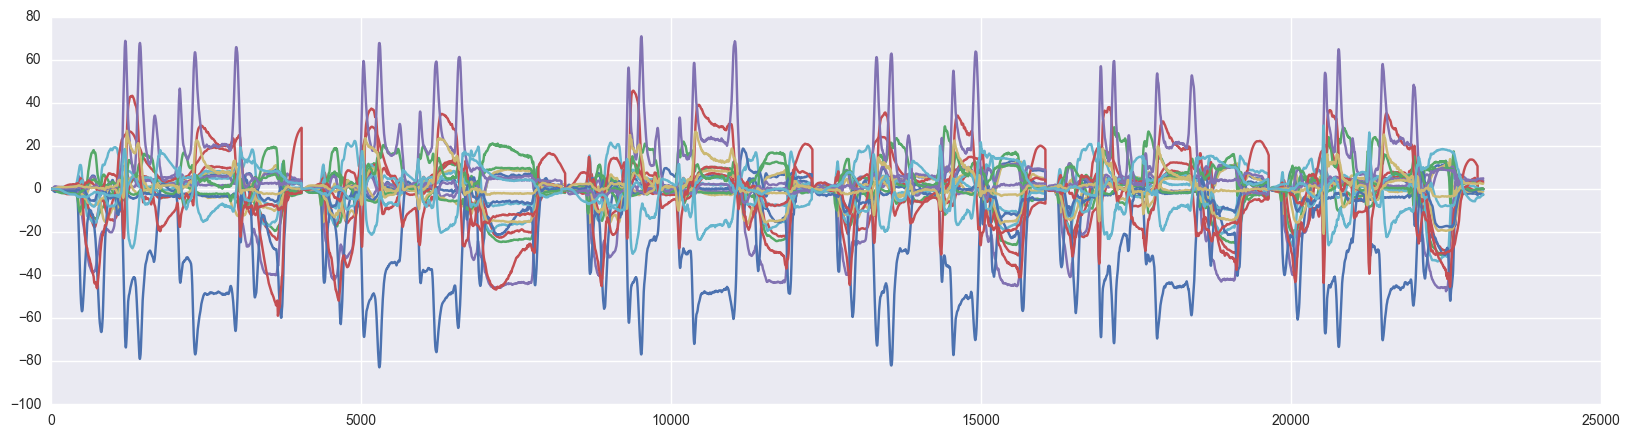

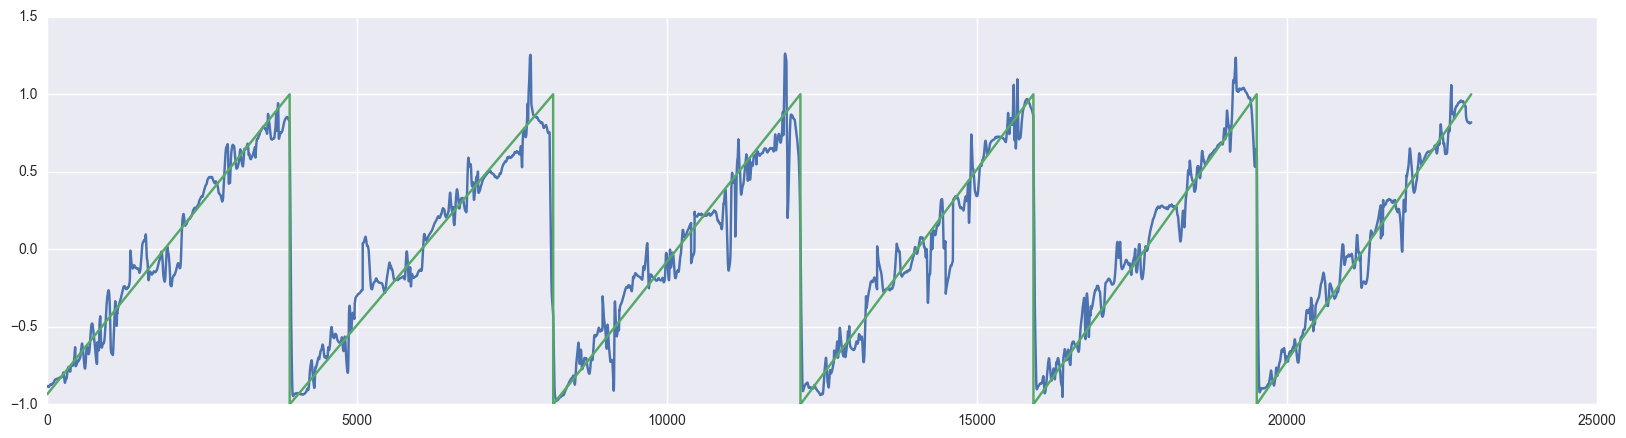

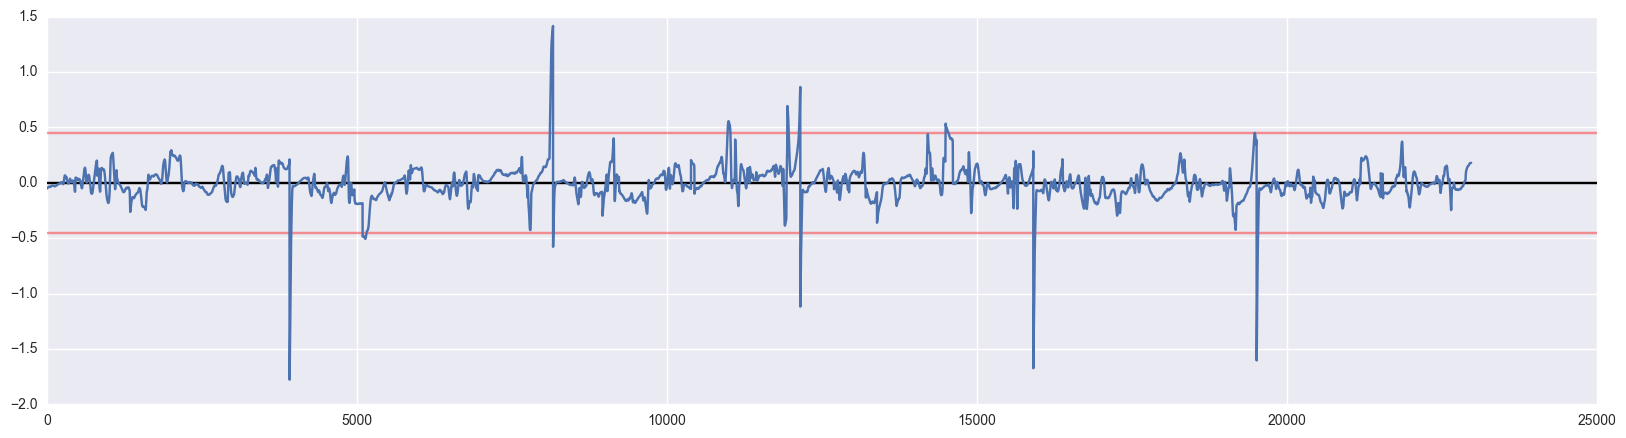

In [29]:
plt.figure(figsize=(20,5))
start=0
size=25000
plt.plot(graph[:size])
plt.figure(figsize=(20,5))
plt.plot(x_pred[start+step_ahead+1:start+step_ahead+size+1,0])
plt.plot(y[start+step_ahead+1:start+step_ahead+size+1])
plt.figure(figsize=(20,5))
plt.plot(error[start+step_ahead+1:start+step_ahead+size+1])
plt.hlines(sigma3 ,0, size,alpha=0.4, color='r')
plt.hlines(-sigma3 ,0, size,alpha=0.4, color='r')
plt.hlines(0 ,0, size)

In [30]:
error_dataFrame=pd.DataFrame()

for i in range(9,11):
    dx = pd.read_csv('data/Test {}_errato/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
    sx = pd.read_csv('data/Test {}_errato/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
    length=np.max([len(dx), len(sx)])
    sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
    target = np.linspace(0,1,length)
    sequence['target']=target
    error_dataFrame=error_dataFrame.append(sequence, ignore_index=True)
    del error_dataFrame['d0']
    del error_dataFrame['s0']
    error_dataFrame=error_dataFrame.fillna(0)

In [31]:
x = x.append(x_test)
x = x.append(error_dataFrame)
graph=np.asarray(x.iloc[:,:-1])
target = x.loc[:,'target']

In [32]:
x_scaled=scaler.transform(x)

In [33]:
x_,y = windowing(x_scaled, window_lenght=input_shape,step_ahead=step_ahead)

In [34]:
x_pred=autoencoder.predict(x_)
x_latent = encoder.predict(x_)
x_real=np.reshape(x_[:,input_shape-1,0], (-1,1))

## Plot of error and encoded representation of the full dataset
**Note:** 
The last three sequences are not in the the training dataset.
The first of these is a correct sequence, whereas the last two are incorrect.

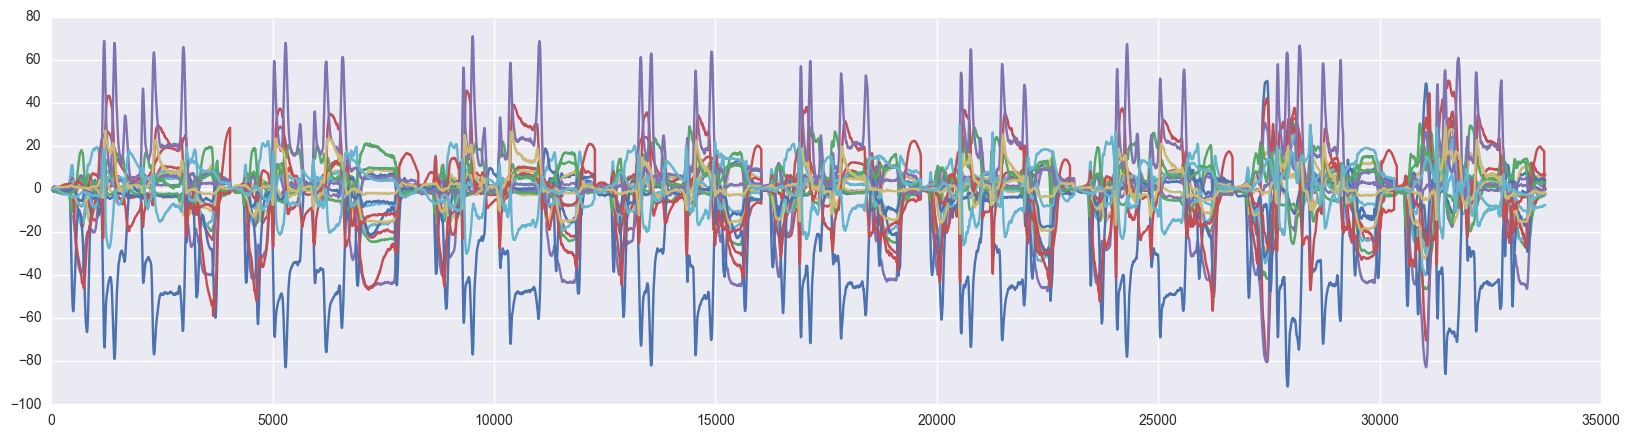

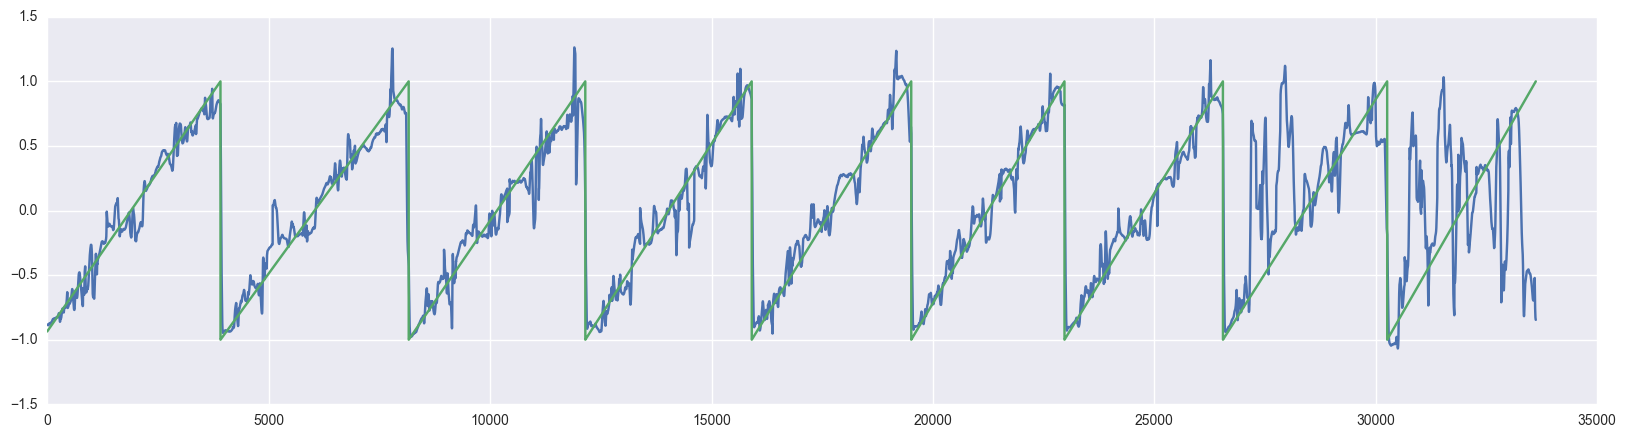

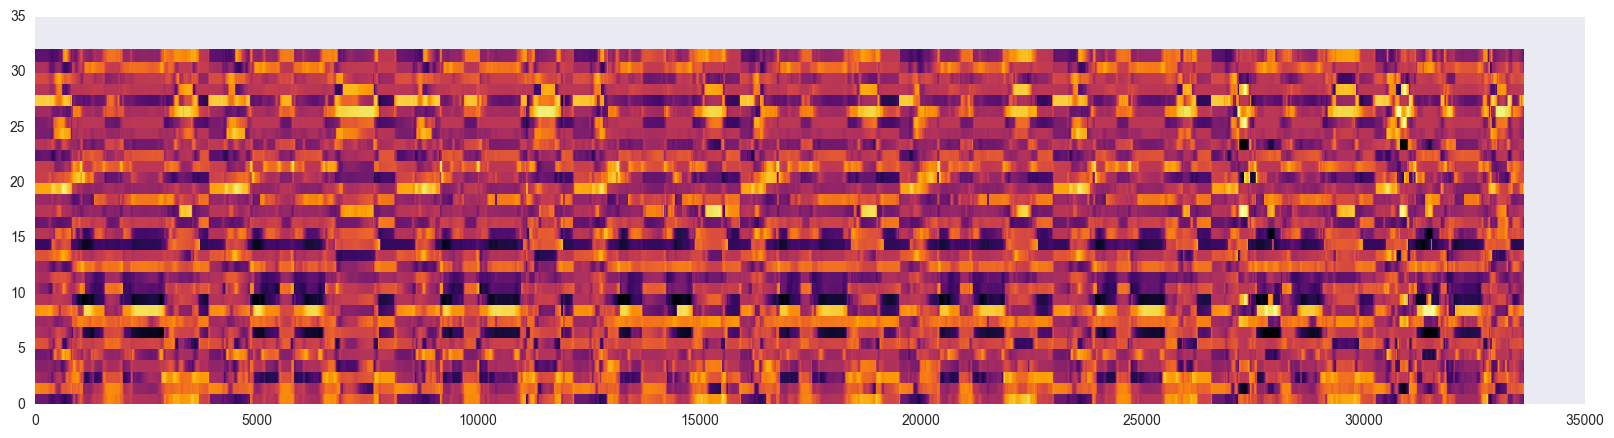

In [42]:
plt.figure(figsize=(20,5))
plt.plot(graph)
plt.figure(figsize=(20,5))
start=0
size=40000
plt.plot(x_pred[start:start+size,:])
plt.plot(y[start:start+size,:])
plt.figure(figsize=(20,5))
plt.pcolor(x_latent[start:start+size,:].T, cmap=plt.cm.inferno)

In [43]:
start=0
size=35000
error=abs(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1])

## Normalized Error plot
The incorrect sequences can be easily spotted due to error's large variance. The spikes in correct sequences are due to sequence ending.

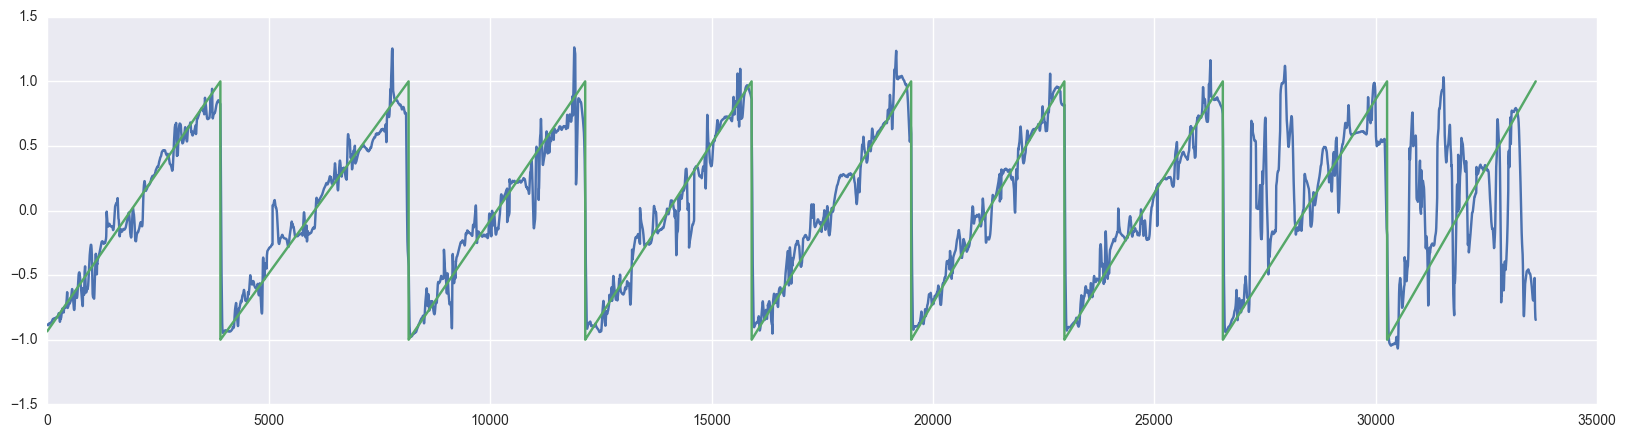

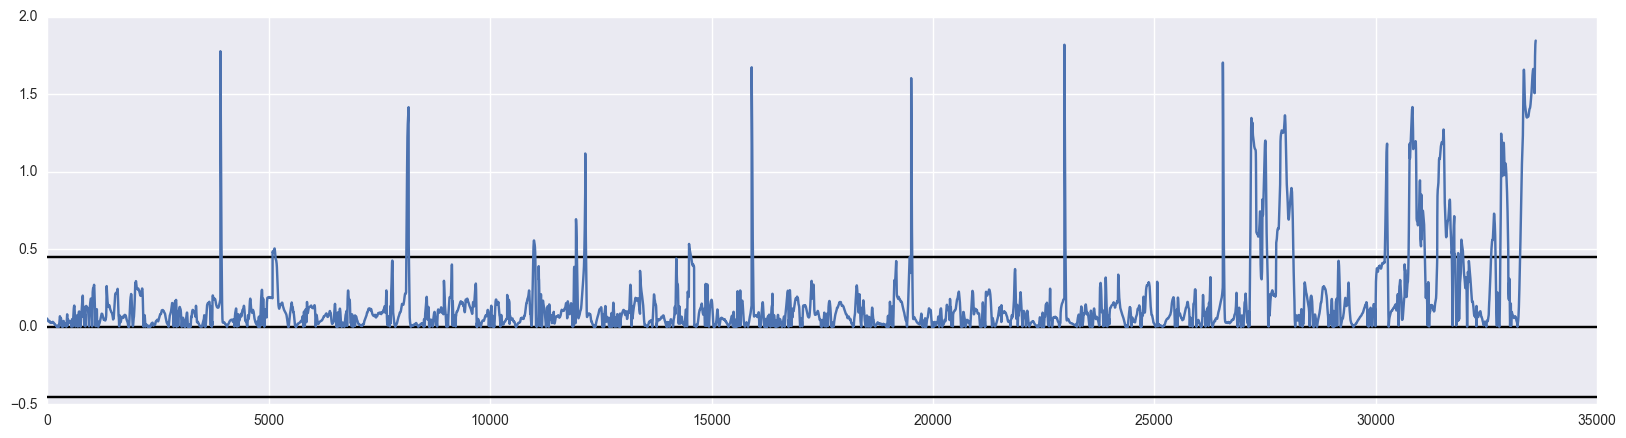

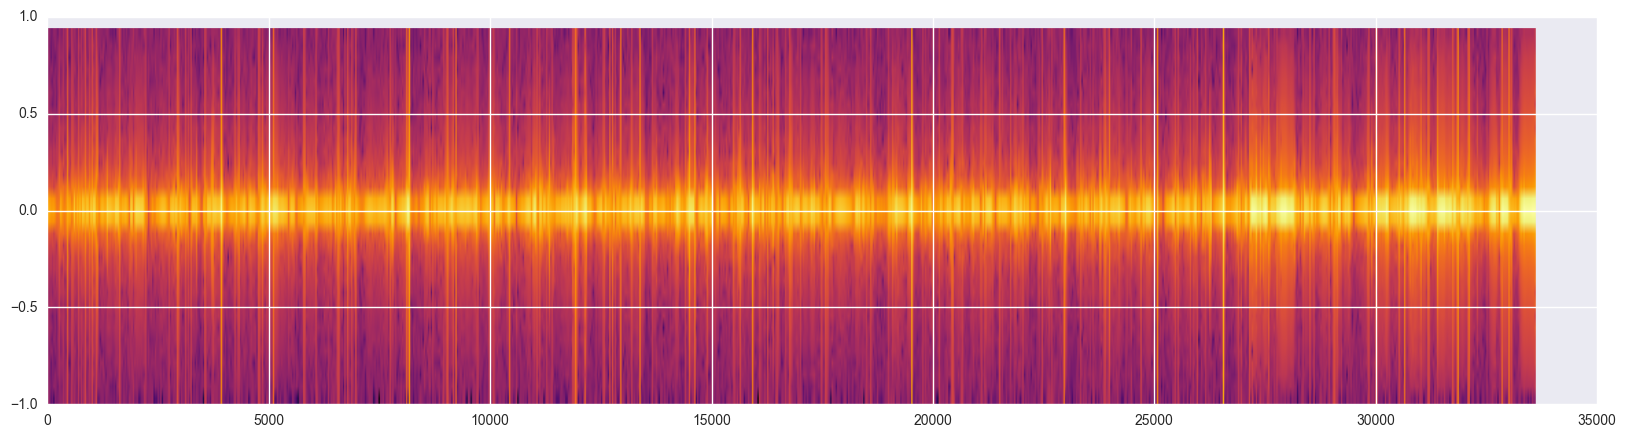

In [44]:
plt.figure(figsize=(20,5))
plt.plot(x_pred[start+step_ahead+1:start+step_ahead+size+1,0])
plt.plot(y[start+step_ahead+1:start+step_ahead+size+1])

plt.figure(figsize=(20,5))
plt.plot(error)
plt.hlines(sigma3 ,0, size)
plt.hlines(-sigma3 ,0, size)
plt.hlines(0 ,0, size)

nfft=32
plt.figure(figsize=(20,5))
values=plt.specgram(error[:,0], 
             NFFT=nfft, 
             noverlap=1, 
             sides='twosided', 
             xextent=(nfft/2.0,
                      len(error)-nfft/2.0),
             cmap='inferno')